# scNym Cell Type Classification with Cell Atlas References

This notebook trains `scNym` cell type classification models using a relevant cell atlas dataset as training data and an unlabeled dataset from new experiment as target data.

We provide cell atlases for the mouse (Tabula Muris) and rat (Rat Aging Cell Atlas).

We demonstrate scNym by training on young rat cells and predicting on old cells.
Simply change the `UPLOAD_NEW_DATA` variable in the cells below to upload your own experiment instead.

In [1]:
%env CUDA_VISIBLE_DEVICES=8

env: CUDA_VISIBLE_DEVICES=8


## Install dependencies and import packages

In [19]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import scnym
import torch

# file downloads
import urllib
import json
import os
import copy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from scnym.api import scnym_api, CONFIGS

## Get links to Cell Atlas datasets

In [4]:
# download a hash table of addresses to pre-formatted cell atlas datasets
cell_atlas_json_url = 'https://storage.googleapis.com/calico-website-scnym-storage/link_tables/cell_atlas.json'
urllib.request.urlretrieve(
    cell_atlas_json_url,
    './cell_atlas.json'
)

with open('./cell_atlas.json', 'r') as f:
  CELL_ATLASES = json.load(f)

In [5]:
print('Available Cell Atlases:')
for k in CELL_ATLASES.keys():
  print(k)

Available Cell Atlases:
mouse
rat


## Download a cell atlas to use as training data

In [6]:
# change this variable to use a different atlas as your
# training data set
ATLAS2USE = 'rat'

if ATLAS2USE not in CELL_ATLASES.keys():
  msg = f'{ATLAS2USE} is not available in the cell atlas directory.'
  raise ValueError(msg)

In [7]:
if not os.path.exists('/dfs/project/CS329D/prabhat/train_data.h5ad'):
  urllib.request.urlretrieve(
      CELL_ATLASES[ATLAS2USE],
      '/dfs/project/CS329D/prabhat/train_data.h5ad',
  )
else:
  print('`train_data.h5ad` is already present.')
  print('Do you really want to redownload it?')
  print('If so, run:')
  print('\t!rm ./train_data.h5ad')
  print('in a cell below.')
  print('Then, rerun this cell.')

`train_data.h5ad` is already present.
Do you really want to redownload it?
If so, run:
	!rm ./train_data.h5ad
in a cell below.
Then, rerun this cell.


In [8]:
train_adata = anndata.read_h5ad('/dfs/project/CS329D/prabhat/train_data.h5ad',)
print('%d cells, %d genes in training data set.' % train_adata.shape)

218971 cells, 32884 genes in training data set.


/afs/cs.stanford.edu/u/prabhat8/dfs/miniconda3/envs/scnym_env/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/afs/cs.stanford.edu/u/prabhat8/dfs/miniconda3/envs/scnym_env/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [9]:
# NOTE: Here we downsample the atlas to avoid memory issues
# with free Colab VMs
MAX_N_CELLS = train_adata.shape[0]
if train_adata.shape[0] > MAX_N_CELLS:
  print('Downsampling training data to fit in memory.')
  print('Note: Remove this step if you have high RAM VMs through Colab Pro.')
  ridx = np.random.choice(train_adata.shape[0], size=MAX_N_CELLS, replace=False)
  train_adata = train_adata[ridx, :]

In [10]:
# filter rare genes to save on memory
n_genes = train_adata.shape[1]
sc.pp.filter_genes(train_adata, min_cells=20)
n_genes -= train_adata.shape[1]
print(f'Removed {n_genes} genes.')
print('%d cells, %d genes in training data set.' % train_adata.shape)

Removed 12767 genes.
218971 cells, 20117 genes in training data set.


In [11]:
# save genes used in the model
np.savetxt('/dfs/project/CS329D/prabhat/model_genes.csv', train_adata.var_names, fmt='%s')

In [12]:
# temporary
model_genes = np.loadtxt('/dfs/project/CS329D/prabhat/model_genes.csv', dtype='str')

## Import a new target data set

Here, we import a target data set that will be used as unlabeled data during training.
We transfer labels from the training data set (e.g. cell atlas) to the target data set in a final prediction step.

This tutorial uses a subset of the rat aging cell atlas as a target data set, but we provide code to upload your own target data set below.
We have found that uploading your data to Google Drive and then importing it to Colab tends to work best.
If you would like to upload your own data, we assume data is located in `/gdrive_root/scnym_data/target_data.h5ad`.
You can change this assumption in the code below to match the location of your data.

If you upload your own dataset, please format it into an `anndata.AnnData` object and normalize counts to `log(CPM + 1)` before using your data with `scNym`.
We also recommend that you filter out cells with low library sizes and genes with few measured cells using standard quality control practices (see [Ilicic et. al. 2016, *Genome Biology*](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0888-1) for details).
We have provided typical threshold values in the code below, but these should be adjusted to match the library size distribution and number of cells in your dataset.

An example of how to format your data is included below.

```python
adata = anndata.AnnData(
  X = X, # [Cells, Genes] scipy.sparse.csr_matrix or numpy.ndarray
  var = var, # [Genes, Features] pd.DataFrame with gene names as the index
  obs = obs, # [Cells, Features] pd.DataFrame with cell barcodes as the index
)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_genes(adata, min_cells=10)
```

In [13]:
# change this variable to `True` if you would
# like to upload your own data
UPLOAD_NEW_DATA = False

In [14]:
# this block uses old cells from the rat aging cell atlas
# as target data and uses only the young cells as training
# data.
# this code will not run if you are uploading your own data
# and changed the variable above.
if not UPLOAD_NEW_DATA:
  # set old cells as target data
  target_adata = train_adata[train_adata.obs['age']!='Y', :]
  # use only young cells are training data
  train_adata = train_adata[train_adata.obs['age']=='Y', :]   

In [15]:
if UPLOAD_NEW_DATA:
  from google.colab import drive
  # mount google drive to the Colab runtime
  drive.mount('/gdrive')
  # define the location of target data in your Google Drive
  # "My\ Drive" is the root of your google drive
  TARGET_PATH = '/gdrive/My\ Drive/scnym_data/target_data.h5ad'

  target_adata = anndata.read_h5ad(
      TARGET_PATH,
  )

In [16]:
print('%d cells, %d genes in the training data.' % train_adata.shape)
print('%d cells, %d genes in the target data.' % target_adata.shape)

72847 cells, 20117 genes in the training data.
146124 cells, 20117 genes in the target data.


## Train an scNym model

Here, we train an scNym model using the MixMatch semi-supervised learning method to transfer lables from the training data set to the target data set.

## Prepare data for training

The scNym API expects a single `anndata.AnnData` object with a column in `AnnData.obs` defining the annotations to learn.
Cells annotated with the special token `"Unlabeled"` will be treated as part of the target dataset.
These cells will be used for semi-supervised and adversarial training.

In [17]:
train_adata.obs['annotations'] = np.array(
    train_adata.obs['cell_ontology_class']
)
target_adata.obs['annotations'] = 'Unlabeled'

adata = train_adata.concatenate(target_adata)
print('%d cells, %d genes in the joined training and target set.' % adata.shape)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


218971 cells, 20117 genes in the joined training and target set.


### Train the scNym model

**NOTE:** Training is computationally expensive and many take 1+ hours using the free Colab GPU.
If you'd like to train more models more quickly, consider [connecting Colab to a local runtime with a GPU](https://research.google.com/colaboratory/local-runtimes.html), using [Colab Pro](https://colab.research.google.com/signup?utm_source=faq&utm_medium=link&utm_campaign=why_arent_resources_guaranteed), or downloading this notebook as a Python script and running it on a GPU equipped machine (e.g. in a cluster at your institution).

scNym saves a copy of the best weights determined using early stopping on the validation criterion in `{out_path}/00_best_model_weights.pkl`.
We load the best weights after training is finished to use for prediction on the target dataset.

In [18]:
scnym_api(
    adata=adata,
    task='train',
    groupby='annotations',
    out_path='/dfs/project/CS329D/prabhat/scnym_outputs',
    config='no_new_identity',
)

CUDA compute device found.
146124 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (72847, 20117)
target   examples:  (146124, 20117)
X:  (72847, 20117)
y:  (72847,)
Not weighting classes and not balancing classes.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Epoch 0/99
----------
Iter :  0
running_sup_loss :  4.173139572143555
running_uns_loss :  0.03015822544693947
running_dom_loss :  0.6952109932899475
running_loss :  4.868350505828857
running_acc  :  0.02734375
corrects: 7.000000 | total: 256.000000
Iter :  100
running_sup_loss :  1.7086383989541838
running_uns_loss :  0.1589415351131765
running_dom_loss :  0.6700605779591173
running_loss :  2.378698982814751
running_acc  :  0.6586478960396039
corrects: 17030.000000 | total: 25856.000000
Iter :  200
running_su

In [19]:
import copy
CONFIGS['no_ssl'] = copy.deepcopy(CONFIGS['default'])
CONFIGS['no_ssl']['ssl_kwargs']['dan_max_weight'] = 0.0
CONFIGS['no_ssl']['ssl_kwargs']['dan_ramp_epochs'] = 1
CONFIGS['no_ssl']['unsup_max_weight'] = 0.0
CONFIGS['no_ssl']['description'] = (
    'Train scNym models with MixMatch but no domain adversary. May be useful if class imbalance is very large.'
)

In [20]:
scnym_api(
    adata=adata,
    task='train',
    groupby='annotations',
    out_path='/dfs/project/CS329D/prabhat/scnym_outputs_no_ssl',
    config=CONFIGS['no_ssl'],
)

CUDA compute device found.
146124 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (72847, 20117)
target   examples:  (146124, 20117)
X:  (72847, 20117)
y:  (72847,)
Not weighting classes and not balancing classes.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 1 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Epoch 0/99
----------
Iter :  0
running_sup_loss :  4.193987846374512
running_uns_loss :  0.023091472685337067
running_dom_loss :  0.706227719783783
running_loss :  4.9002156257629395
running_acc  :  0.015625
corrects: 4.000000 | total: 256.000000
Iter :  100
running_sup_loss :  1.7235442789474336
running_uns_loss :  0.15065104861070613
running_dom_loss :  0.6714024933257906
running_loss :  2.394946767552064
running_acc  :  0.6567914603960396
corrects: 16982.000000 | total: 25856.000000
Iter :  200
running_sup

In [20]:
CONFIGS['only_dan'] = copy.deepcopy(CONFIGS['default'])
CONFIGS['only_dan']['unsup_max_weight'] = 0.0
CONFIGS['only_dan']['description'] = (
    'Train scNym models with only domain adversary. '
)
CONFIGS['only_dan']

{'n_epochs': 100,
 'lr': 1.0,
 'optimizer_name': 'adadelta',
 'weight_decay': 0.0001,
 'batch_size': 256,
 'mixup_alpha': 0.3,
 'unsup_max_weight': 0.0,
 'unsup_mean_teacher': False,
 'ssl_method': 'mixmatch',
 'ssl_kwargs': {'augment_pseudolabels': False,
  'augment': 'log1p_drop',
  'unsup_criterion': 'mse',
  'n_augmentations': 1,
  'T': 0.5,
  'ramp_epochs': 100,
  'burn_in_epochs': 0,
  'dan_criterion': True,
  'dan_ramp_epochs': 20,
  'dan_max_weight': 0.1},
 'model_kwargs': {'n_hidden': 256,
  'n_layers': 2,
  'init_dropout': 0.0,
  'residual': False},
 'description': 'Train scNym models with only domain adversary. '}

In [21]:
scnym_api(
    adata=adata,
    task='train',
    groupby='annotations',
    out_path='/dfs/project/CS329D/prabhat/scnym_outputs_only_dan',
    config=CONFIGS['only_dan'],
)

CUDA compute device found.
146124 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (72847, 20117)
target   examples:  (146124, 20117)
X:  (72847, 20117)
y:  (72847,)
{'augment_pseudolabels': False, 'augment': 'log1p_drop', 'unsup_criterion': 'mse', 'n_augmentations': 1, 'T': 0.5, 'ramp_epochs': 100, 'burn_in_epochs': 0, 'dan_criterion': True, 'dan_ramp_epochs': 20, 'dan_max_weight': 0.1}
Not weighting classes and not balancing classes.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 20 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Epoch 0/99
----------
Iter :  0
running_sup_loss :  4.107385635375977
running_uns_loss :  0.02675737626850605
running_dom_loss :  0.7168366312980652
running_loss :  4.824222087860107
running_acc  :  0.01953125
corrects: 5.000000 | total: 256.000000
Iter :  100
running_sup_loss :  1.685247

In [25]:
scnym_api(
    adata=adata,
    task='train',
    groupby='annotations',
    out_path='/dfs/project/CS329D/prabhat/scnym_outputs_no_dan',
    config='no_dan',
)

CUDA compute device found.
146124 unlabeled observations found.
Using unlabeled data as a target set for semi-supervised, adversarial training.

training examples:  (72847, 20117)
target   examples:  (146124, 20117)
X:  (72847, 20117)
y:  (72847,)
{'augment_pseudolabels': False, 'augment': 'log1p_drop', 'unsup_criterion': 'mse', 'n_augmentations': 1, 'T': 0.5, 'ramp_epochs': 100, 'burn_in_epochs': 0, 'dan_criterion': True, 'dan_ramp_epochs': 1, 'dan_max_weight': 0.0}
Not weighting classes and not balancing classes.
Using MixMatch for semi-supervised learning
Scaling ICL over 100 epochs, 0 epochs for burn in.
Scaling ICL over 1 epochs, 0 epochs for burn in.
Using a Domain Adaptation Loss.
Training...
Epoch 0/99
----------
Iter :  0
running_sup_loss :  4.101791858673096
running_uns_loss :  0.02261034958064556
running_dom_loss :  0.7032411098480225
running_loss :  4.805032730102539
running_acc  :  0.0078125
corrects: 2.000000 | total: 256.000000
Iter :  100
running_sup_loss :  1.679718480

In [1]:
import argparse
import copy
import json
import os
# plotting
import sys
# file downloads
import urllib

import anndata
import numpy as np
import scanpy as sc
sys.path.insert(0, "/afs/cs.stanford.edu/u/prabhat8/cs329d/CS329D/scnym")
from scnym.api import scnym_api, CONFIGS

CONFIGS['no_ssl'] = copy.deepcopy(CONFIGS['default'])
CONFIGS['no_ssl']['ssl_method'] = 'sup_only'
CONFIGS['no_ssl']['ssl_kwargs']['dan_max_weight'] = 0.0
CONFIGS['no_ssl']['ssl_kwargs']['dan_ramp_epochs'] = 1
CONFIGS['no_ssl']['ssl_kwargs']['dan_criterion'] = None
CONFIGS['no_ssl']['unsup_max_weight'] = 0.0
CONFIGS['no_ssl']['description'] = (
    'Train scNym models no SSL'
)

CONFIGS['only_dan'] = copy.deepcopy(CONFIGS['default'])
CONFIGS['only_dan']['mixup_alpha'] = None
CONFIGS['only_dan']['ssl_method'] = 'sup_only'
CONFIGS['only_dan']['unsup_max_weight'] = 0.0
CONFIGS['only_dan']['description'] = (
    'Train scNym models with only domain adversary.'
)

CONFIGS['no_dan'] = copy.deepcopy(CONFIGS['default'])
CONFIGS['no_dan']['ssl_kwargs']['dan_max_weight'] = 0.0
CONFIGS['no_dan']['ssl_kwargs']['dan_ramp_epochs'] = 1
CONFIGS['no_dan']['ssl_kwargs']['dan_criterion'] = None
CONFIGS['no_dan']['description'] = (
    'Train scNym models with MixMatch but no domain adversary. May be useful if class imbalance is very large.'
)

## Predict cell types in target data

After training the model, we load the best set of weights selected using early stopping and predict cell types for the target data set.

In [27]:
!ls /dfs/project/CS329D/prabhat/scnym_outputs_no_ssl  

00_best_model_weights.pkl   model_weights_024.pkl  predictions.csv
01_final_model_weights.pkl  model_weights_030.pkl  scnym_outputs_no_ssl_log.csv
02_best_dan_weights.pkl     model_weights_040.pkl  scnym_train_results.pkl
labels.csv		    model_weights_045.pkl  tblog
model_weights_000.pkl	    model_weights_051.pkl  test_idx.csv
model_weights_020.pkl	    model_weights_060.pkl  train_idx.csv
model_weights_021.pkl	    model_weights_080.pkl  val_idx.csv


In [12]:
!ls /dfs/project/CS329D/prabhat/final/models/hb_target/0/

annotations.csv  scnym_outputs_no_ssl


In [2]:
def get_data_hb(basedir):
    adata = sc.read_h5ad('/dfs/project/CS329D/data/kang_2017_stim_pbmc.h5ad')
    train_adata = adata[adata.obs['stim'] == 'ctrl']
    target_adata = adata[adata.obs['stim'] == 'stim']

    train_adata.obs['annotations'] = np.array(
        train_adata.obs['cell']
    )
    target_adata.obs['annotations'] = 'Unlabeled'

    adata = train_adata.concatenate(target_adata)
    # adata = train_adata
    print('%d cells, %d genes in the joined training and target set.' % adata.shape)

    # save genes used in the model
#     np.savetxt(f'{basedir}/model_genes.csv', train_adata.var_names, fmt='%s')
#     model_genes = np.loadtxt(f'{basedir}/model_genes.csv', dtype='str')

    return adata

hb_adata = get_data_hb('/dfs/project/CS329D/prabhat/temp')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


29056 cells, 35635 genes in the joined training and target set.


In [3]:
scnym_api(
    adata=hb_adata,
    task='predict',
    key_added=f'no_ssl',
    config=CONFIGS['no_ssl'],
    trained_model='/dfs/project/CS329D/prabhat/final/models/hb/0/scnym_outputs_no_ssl'
)

CUDA compute device found.


Finding cell types:   0%|          | 0/29 [00:00<?, ?it/s]

Loaded model predicting 8 classes from 35635 features
['B cells' 'CD14+ Monocytes' 'CD4 T cells' 'CD8 T cells' 'Dendritic cells'
 'FCGR3A+ Monocytes' 'Megakaryocytes' 'NK cells']
Building a classification matrix...
Gene names match exactly, returning input.
Predicting cell types...


Finding cell types: 100%|██████████| 29/29 [00:06<00:00,  4.48it/s]


Extracting model embeddings...


In [38]:
def get_acc(data, key):
    
    return np.sum(np.array(data.obs[key].values) == np.array(data.obs['cell_ontology_class'].values))/\
                len(data)

def print_acc(model, config):
    scnym_api(
        adata=adata,
        task='predict',
        key_added=model,
        config=config,
        trained_model=f'/dfs/project/CS329D/prabhat/{model}'
    )
    target_adata = adata[adata.obs['annotations']=='Unlabeled', :]
    source_data = adata[adata.obs['annotations']!='Unlabeled', :]
    print(model, get_acc(adata, model), get_acc(target_adata, model), get_acc(source_data, model),)

In [39]:
for model, config in [('scnym_outputs', 'no_new_identity'), ('scnym_outputs_no_ssl', CONFIGS['no_ssl']),
                     ('scnym_outputs_no_dan', 'no_dan'), ('scnym_outputs_only_dan', CONFIGS['only_dan'])]:
    print_acc(model, config)

CUDA compute device found.
Loaded model predicting 55 classes from 20117 features
['B cell' 'Kupffer cell' 'Langerhans cell' 'T cell' 'Unknown'
 'alternatively activated macrophage' 'aorta-localized proliferative cell'
 'astrocyte' 'basal cell' 'basophil' 'cholangiocyte' 'cycling cell'
 'dendritic cell' 'endothelial cell' 'epithelial cell'
 'epithelial cell of proximal tubule' 'erythroblast' 'excitatory neuron'
 'fast muscle cell' 'fibroblast' 'hair follicle cell' 'hepatocyte'
 'immature B cell' 'immature conventional dendritic cell'
 'immature neutrophil' 'inhibitory neuron' 'keratinocyte'
 'kidney collecting duct intercalated cell'
 'kidney collecting duct principal cell'
 'kidney distal convoluted tubule epithelial cell'
 'kidney loop of Henle ascending limb epithelial cell'
 'kidney loop of Henle descending limb epithelial cell' 'late pro-B cell'
 'leptomeningeal cell' 'macrophage' 'mature NK T cell' 'megakaryocyte'
 'mesenchymal stem cell' 'microglia' 'monocyte' 'natural killer ce

Finding cell types: 100%|██████████| 214/214 [00:52<00:00,  4.05it/s]


Extracting model embeddings...


Finding cell types:   0%|          | 0/214 [00:00<?, ?it/s]

scnym_outputs 0.938868617305488 0.9159549423777066 0.9848312216014387
CUDA compute device found.
Loaded model predicting 55 classes from 20117 features
['B cell' 'Kupffer cell' 'Langerhans cell' 'T cell' 'Unknown'
 'alternatively activated macrophage' 'aorta-localized proliferative cell'
 'astrocyte' 'basal cell' 'basophil' 'cholangiocyte' 'cycling cell'
 'dendritic cell' 'endothelial cell' 'epithelial cell'
 'epithelial cell of proximal tubule' 'erythroblast' 'excitatory neuron'
 'fast muscle cell' 'fibroblast' 'hair follicle cell' 'hepatocyte'
 'immature B cell' 'immature conventional dendritic cell'
 'immature neutrophil' 'inhibitory neuron' 'keratinocyte'
 'kidney collecting duct intercalated cell'
 'kidney collecting duct principal cell'
 'kidney distal convoluted tubule epithelial cell'
 'kidney loop of Henle ascending limb epithelial cell'
 'kidney loop of Henle descending limb epithelial cell' 'late pro-B cell'
 'leptomeningeal cell' 'macrophage' 'mature NK T cell' 'megakaryocy

Finding cell types: 100%|██████████| 214/214 [00:52<00:00,  4.05it/s]


Extracting model embeddings...


Finding cell types:   0%|          | 0/214 [00:00<?, ?it/s]

scnym_outputs_no_ssl 0.9364664727292655 0.9126769045468233 0.9841860337419523
CUDA compute device found.
Loaded model predicting 55 classes from 20117 features
['B cell' 'Kupffer cell' 'Langerhans cell' 'T cell' 'Unknown'
 'alternatively activated macrophage' 'aorta-localized proliferative cell'
 'astrocyte' 'basal cell' 'basophil' 'cholangiocyte' 'cycling cell'
 'dendritic cell' 'endothelial cell' 'epithelial cell'
 'epithelial cell of proximal tubule' 'erythroblast' 'excitatory neuron'
 'fast muscle cell' 'fibroblast' 'hair follicle cell' 'hepatocyte'
 'immature B cell' 'immature conventional dendritic cell'
 'immature neutrophil' 'inhibitory neuron' 'keratinocyte'
 'kidney collecting duct intercalated cell'
 'kidney collecting duct principal cell'
 'kidney distal convoluted tubule epithelial cell'
 'kidney loop of Henle ascending limb epithelial cell'
 'kidney loop of Henle descending limb epithelial cell' 'late pro-B cell'
 'leptomeningeal cell' 'macrophage' 'mature NK T cell' 'meg

Finding cell types: 100%|██████████| 214/214 [00:52<00:00,  4.07it/s]


Extracting model embeddings...
scnym_outputs_no_dan 0.9386083088628174 0.9159891598915989 0.9839801227229673
CUDA compute device found.
Loaded model predicting 55 classes from 20117 features
['B cell' 'Kupffer cell' 'Langerhans cell' 'T cell' 'Unknown'
 'alternatively activated macrophage' 'aorta-localized proliferative cell'
 'astrocyte' 'basal cell' 'basophil' 'cholangiocyte' 'cycling cell'
 'dendritic cell' 'endothelial cell' 'epithelial cell'
 'epithelial cell of proximal tubule' 'erythroblast' 'excitatory neuron'
 'fast muscle cell' 'fibroblast' 'hair follicle cell' 'hepatocyte'
 'immature B cell' 'immature conventional dendritic cell'
 'immature neutrophil' 'inhibitory neuron' 'keratinocyte'
 'kidney collecting duct intercalated cell'
 'kidney collecting duct principal cell'
 'kidney distal convoluted tubule epithelial cell'
 'kidney loop of Henle ascending limb epithelial cell'
 'kidney loop of Henle descending limb epithelial cell' 'late pro-B cell'
 'leptomeningeal cell' 'macr

Finding cell types: 100%|██████████| 214/214 [00:49<00:00,  4.34it/s]


Extracting model embeddings...
scnym_outputs_only_dan 0.942257193874988 0.9219498508116394 0.9829917498318393


In [40]:
for model, config in [('scnym_outputs', 'no_new_identity'), ('scnym_outputs_no_ssl', CONFIGS['no_ssl']),
                     ('scnym_outputs_no_dan', 'no_dan'), ('scnym_outputs_only_dan', CONFIGS['only_dan'])]:
    target_adata = adata[adata.obs['annotations']=='Unlabeled', :]
    source_data = adata[adata.obs['annotations']!='Unlabeled', :]
    print(model, get_acc(adata, model), get_acc(target_adata, model), get_acc(source_data, model),)

scnym_outputs 0.938868617305488 0.9159549423777066 0.9848312216014387
scnym_outputs_no_ssl 0.9364664727292655 0.9126769045468233 0.9841860337419523
scnym_outputs_no_dan 0.9386083088628174 0.9159891598915989 0.9839801227229673
scnym_outputs_only_dan 0.942257193874988 0.9219498508116394 0.9829917498318393


## Plot cell type predictions

In [ ]:
def match_colors(
    adata: anndata.AnnData,
    source_cat: str,
    target_cat: str,
    extend_pal=sns.color_palette('tab20'),
) -> anndata.AnnData:
    '''Match the colors used for common categories across categorical
    variables in a an AnnData object.
    
    Parameters
    ----------
    adata : anndata.AnnData
        [Cells, Genes] with `source_cat` and `target_cat` in `.obs`
        if source colors not present in `.uns[f"{source_cat}_colors"]`,
        they will be added using `extend_pal`.
    source_cat : str
        source categorical with a set of colors to copy.
    target_cat : str
        target categorical that will adopt colors from `source_cat`.
        
    Returns
    -------
    adata : anndata.AnnData
        [Cells, Genes]
    '''
    adata.obs[source_cat] = pd.Categorical(adata.obs[source_cat].tolist())
    if f'{source_cat}_colors' not in adata.uns.keys():
        sc.pl._utils.add_colors_for_categorical_sample_annotation(
            adata,
            source_cat,
            palette=extend_pal,
        )
    
    # define an rgb to hex mapping
    rgb2hex = lambda r,g,b: f'#{r:02x}{g:02x}{b:02x}'
    
    source_colors = adata.uns[f'{source_cat}_colors']
    source_levels = pd.Categorical(adata.obs[source_cat]).categories
    
    source_colors = {
        source_levels[i]: source_colors[i] for i in range(len(source_colors))
    }

    target_levels = pd.Categorical(adata.obs[target_cat]).categories
    target_colors = []
    
    i = 0 # how many keys have we added from the source colors?
    j = 0 # how many colors have we used from the extending palette?
    for target_lev in target_levels:
        if target_lev in source_colors.keys():
            target_colors.append(source_colors[target_lev])
            i += 1
        else:
            idx2get = len(source_colors)+j+1
            target_colors.append(
                rgb2hex(*(np.array(extend_pal[idx2get%len(extend_pal)])*255).astype(np.int))
            )
            j += 1
    adata.uns[f'{target_cat}_colors'] = target_colors
    
    return adata

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'GSM' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'age' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'annotations' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'scNym' as categorical


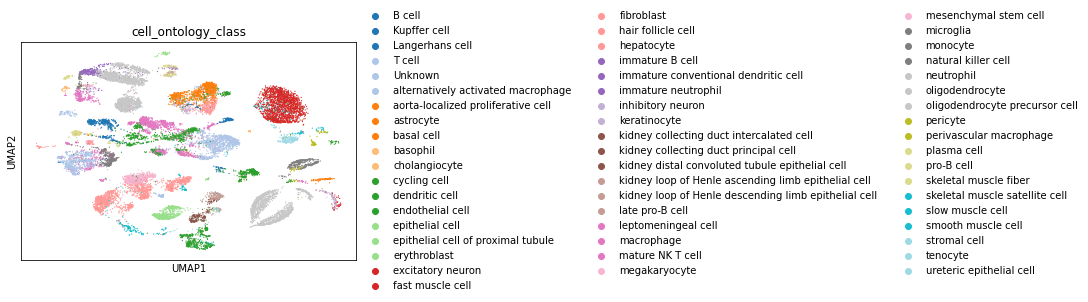

In [ ]:
sc.pl.umap(
    target_adata,
    color='cell_ontology_class',
    palette='tab20',
)

In [ ]:
target_adata = match_colors(
    adata=target_adata,
    source_cat='cell_ontology_class',
    target_cat='scNym',
)

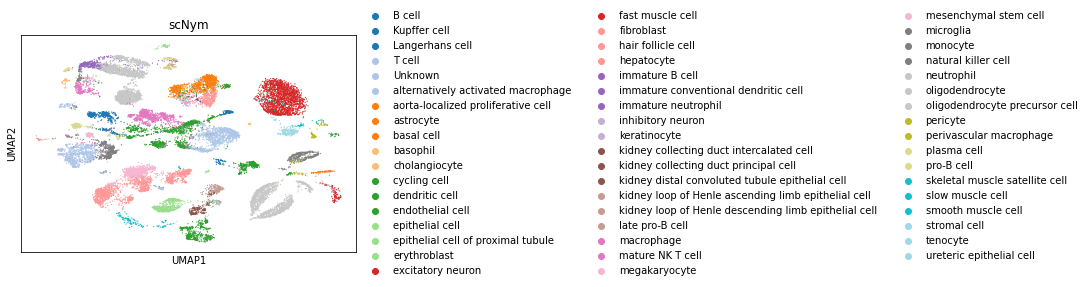

In [ ]:
sc.pl.umap(
    target_adata,
    color='scNym',
)

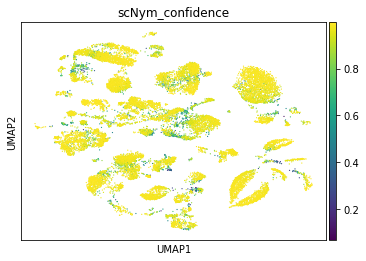

In [ ]:
sc.pl.umap(
  target_adata,
  color='scNym_confidence',
)

## Plot model embeddings

`scnym_api` also extracts the activations of the penultimate neural network layer. These activations represent the embedding learned by the scNym model.

In [4]:
sc.pp.neighbors(hb_adata, use_rep='X_scnym', n_neighbors=30)

In [5]:
sc.tl.umap(hb_adata, min_dist=0.3)

... storing 'stim' as categorical
... storing 'annotations' as categorical
... storing 'no_ssl' as categorical


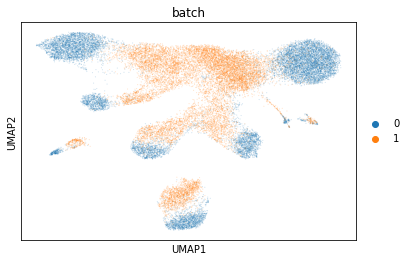

In [6]:
sc.pl.umap(hb_adata, color='batch', size=5., alpha=0.2)

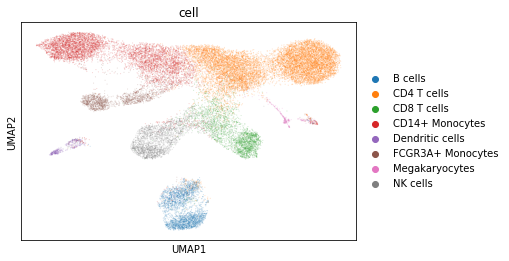

In [7]:
sc.pl.umap(hb_adata, color='cell', size=5., alpha=0.2)

## Save scNym annotations to locally or to gDrive

In [ ]:
target_adata.obs.to_csv(
    './annotations.csv'
)

In [ ]:
# save files locally
from google.colab import files

files.download('annotations.csv')

In [ ]:
# save files to Google Drive
from google.colab import drive
drive.mount('/gdrive')

# make a directory if not present already
!mkdir "/gdrive/My Drive/scnym/"
# copy file to gDrive
!cp annotations.csv "/gdrive/My Drive/scnym/annotations.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
mkdir: cannot create directory ‘/gdrive/My\\ Drive/scnym/’: No such file or directory
cp: cannot create regular file '/gdrive/My\ Drive/scnym/annotations.csv': No such file or directory


In [ ]:
no_new_identity 0.9419557840992643 0.9205264022337193 0.984941040811564
no_ssl 0.9381698946435829 0.9158796638471435 0.982881930621714
no_dan 0.9386768110845728 0.9154553666748789 0.9852567710406743
only_dan 0.9380374570148559 0.9164408310749774 0.9813581890812251

In [ ]:
# PB
no_new_identity 0.9515074339207048 0.9193685402803341 0.9819156061620897
only_dan 0.951954845814978 0.9175987540705083 0.9844608171466845
no_dan 0.9498210352422908 0.9132804757185332 0.9843938379102478
no_ssl 0.9493047907488987 0.9134220586153192 0.9832551908908238

In [ ]:
no_ssl 0.8745870044052864 0.7582472037377884 0.9846617548559946
no_dan 0.9490982929515418 0.914979470479966 0.9813797722705961

only_dan 0.9501651982378855 0.9142715559960357 0.984125920964501
only_dan 0.9517483480176211 0.9173863797253292 0.9842598794373744

In [51]:
from pprint import pprint
with open(os.path.join('/dfs/project/CS329D/prabhat/final', 'results', 'hb', 'only_dan', 'results.json'), 'r') as f:
    accuracies = json.load(f)['accuracies']
pprint(accuracies)
vals = [np.mean(x) for x in accuracies]
print(np.mean(vals), np.std(vals))
# final_result = {}
# for class_ in accuracies[0].keys():
#     final_result[class_] = {}
#     if class_ == 'accuracy':
#         continue
#     for metric in accuracies[0][class_].keys():
#         #print(class_, metric)
#         vals = [accuracy[class_][metric] for accuracy in accuracies]
#         final_result[class_][metric] = np.mean(vals), np.std(vals)
# final_result

[[0.9690721649484536,
  0.9790975447909754,
  0.9708474576271187,
  0.8616404308202155,
  0.7416666666666667,
  0.6785350966429298,
  0.5,
  0.7984],
 [0.9705449189985272,
  0.9834107498341075,
  0.967457627118644,
  0.8566694283347142,
  0.7583333333333333,
  0.6673448626653102,
  0.5057471264367817,
  0.7944],
 [0.9705449189985272,
  0.9903782349037823,
  0.9650847457627119,
  0.8467274233637117,
  0.7208333333333333,
  0.6032553407934893,
  0.2988505747126437,
  0.788]]
0.799451749170249 0.01873447728452014


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
sns.set_style("ticks")
sns.set_context("paper")

Text(0, 0.5, 'Macro Accuracy')

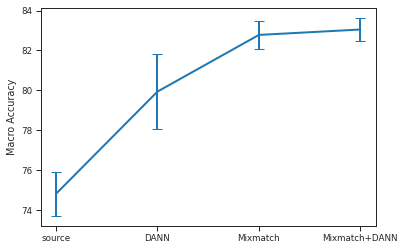

In [59]:
axis = ['source', 'DANN', 'Mixmatch', 'Mixmatch+DANN']
x = [74.82, 79.94, 82.78, 83.05]
err = [1.09, 1.87, 0.69, 0.58]

plt.errorbar(x=axis, y=x, yerr=err,  fmt='-', capsize=5, linewidth=2 )
plt.ylabel('Macro Accuracy')


Text(0, 0.5, 'Macro Accuracy')

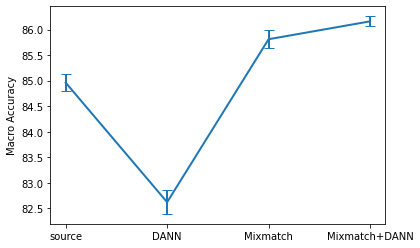

In [10]:
axis = ['source', 'DANN', 'Mixmatch', 'Mixmatch+DANN']
x = [84.96, 82.62, 85.81, 86.16]
err = [0.17, 0.23, 0.18, 0.10]

plt.errorbar(x=axis, y=x, yerr=err,  fmt='-', capsize=5, linewidth=2 )
plt.ylabel('Macro Accuracy')

In [11]:
x = [91.43, 90.66, 93.06]
np.mean(x), np.std(x)

(91.71666666666665, 1.0005442963152067)

In [17]:
import pandas as pd
obs = anndata.read_csv('/dfs/project/CS329D/prabhat/final/models/hb_target/0/annotations.csv')

IndexError: list index out of range

In [20]:
x = [0.9249827942188575, 0.9225739848589126, 0.9308327598072953]
np.mean(x)*100, np.std(x)*100

(92.6129846295022, 0.34678174943406787)